<a href="https://colab.research.google.com/github/SRI-CSL/signal-public/blob/signal-demonstration/colabs/signal_interest_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SIGNAL**ing Interest Data

**Description:** Generating `interest` dataframe via SIGNAL API.

**Copyright 2022 SRI International.**

This project is under the GPL3 License. See the [LICENSE](https://www.gnu.org/licenses/gpl-3.0.en.html) file for the full license text.

## &#9776; Preamble

Install the `SIGNAL API` client

In [ ]:
!curl https://signal.cta.sri.com/client > client.tgz
!tar xzf client.tgz
!pip install -r signal_api_client/requirements.txt
!pip install -e signal_api_client
!pip install ipympl
%cd /content/signal_api_client   

Download the `funcs` utilities repository.

In [1]:
!git clone https://github.com/hsanchez/funcs.git &> /dev/null

## &#9776; Dependencies

In [2]:
import os
import sys
import time
import warnings

import json
import pickle
import pathlib
import zipfile
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Any, Dict, Tuple
from datetime import date, datetime

In [3]:
os.chdir(f'./funcs')
!git fetch

In [4]:
!git checkout activity_roles_detection_colab &> /dev/null

In [5]:
import funcs as utils

In [6]:
import spacy

In [7]:
# try:
#     from google.colab import data_table, output
#     data_table.disable_dataframe_formatter()
#     output.enable_custom_widget_manager()
# except Exception:
#     print("Launched notebook locally")

In [8]:
# from signal_api import signal

## &#9997; Configuration

In [9]:
warnings.filterwarnings("ignore")

In [10]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [11]:
pd.options.display.float_format = "{:,.8f}".format

In [12]:
np.random.seed(0)

In [13]:
nlp = spacy.load('en_core_web_sm')

In [14]:
from IPython import get_ipython
utils.common.set_default_vars(os.environ, ipython_val=get_ipython())

In [15]:
utils.console.stdout.print(utils.common.is_run_in_colab())

True

In [30]:
DATA_DICT = {
    "linux-kernel-data.zip": "1h1AGfQkOhvgtcCR8tWVzObBSpBTURWM2",
    "lkml_email_patches_data.zip" : "12V2v3BNjF4RLkvKQZIBEqnBfqxQN1iVK",
    "lkml_content_all.csv": "1iksk8RkfXEk07B5rSoN8JRz_bxukDnuC"
    }

## &#9881; Functions

In [12]:
# B.H. note: Add functions that are not already in funcs here...

In [13]:
def get_record_count(table_name: str) -> int:
    query = f"SELECT COUNT(*) FROM {table_name};"
    df_result = signal.query_dataframe(query)
    result = df_result['count'].iloc[0]
    return result

### &#9759; Bot Analysis Functions

In [14]:
REGEX_GREG_ADDED = re.compile('patch \".*\" added to .*')

BOTS = {'tip-bot2@linutronix.de', 'tipbot@zytor.com', 'tip-bot2@tip-bot2',
        'lkp@ff58d72860ac', 'lkp@shao2-debian', 'lkp@xsang-OptiPlex-9020',
        'rong.a.chen@shao2-debian', 'lkp@b50bd4e4e446', 'rong.a.chen@shao2-debian',
        'noreply@ciplatform.org', 'patchwork@emeril.freedesktop.org',
        'pr-tracker-bot@kernel.org'}
        
POTENTIAL_BOTS = {'broonie@kernel.org', 'lkp@intel.com',
                  'boqun.feng@debian-boqun.qqnc3lrjykvubdpftowmye0fmh.lx.internal.cloudapp.net'}

In [15]:
def is_bot(patch: dict) -> bool:
    email_address = patch['email']
    if email_address in BOTS:
        return True
    
    subject_line = patch.get('subject', '')
    if email_address in POTENTIAL_BOTS:
        # Mark Brown's bot and lkp
        if subject_line.startswith('applied'):
            return True
    sender_name = patch.get('senderName', None)
    sender_name = patch.get('name', '') if sender_name is None else sender_name
    if 'tip-bot2' in sender_name or 'syzbot' in sender_name:
        return True
    if 'tip-bot' in sender_name:
        return True
    if sender_name in POTENTIAL_BOTS:
        return True
    if 'kernel test robot' in sender_name:
        return True
    
    if REGEX_GREG_ADDED.match(subject_line):
        return True
    
    # AKPM's bot. AKPM uses s-nail for automated mails, and sylpheed for all
    # other mails. That's how we can easily separate automated mails from
    # real mails. Further, akpm acts as bot if the subject contains [merged]
    if email_address == 'akpm@linux-foundation.org':
        if '[merged]' in subject_line:
            return True

    # syzbot - email format: syzbot-hash@syzkaller.appspotmail.com
    if 'syzbot' in email_address and 'syzkaller.appspotmail.com' in email_address:
        return True
    
    # Github Bot
    if 'noreply@github.com' in email_address:
        return True
    
    # Buildroot's daily results bot
    if '[autobuild.buildroot.net] daily results' in subject_line or \
        'oe-core cve metrics' in subject_line:
            return True
    
    return False

### &#9759; NLP

In [16]:
def fkre_score(total_words: int, total_sentences: int, total_syllables: int) -> float:
    """Flesch Kincaid Reading Ease (FKRE) score"""

    return round(206.835 - 1.015 * (total_words/total_sentences) - 84.6 * (total_syllables/total_words), 2)

In [17]:
def fkgl_score(total_words: int, total_sentences: int, total_syllables: int) -> float:
    """Flesch Kincaid Grade Level (FKGL) score"""

    return round(0.39 * (total_words/total_sentences) + 11.8 * (total_syllables/total_words) - 15.59, 2)

In [18]:
def count_syllables(word):
    """source: https://codereview.stackexchange.com/questions/224177/python-function-to-count-syllables-in-a-word"""
    return len(
        re.findall('(?!e$)[aeiouy]+', word, re.I) +
        re.findall('^[^aeiouy]*e$', word, re.I)
    )

In [19]:
def message_length(email_body: str) -> int:
    return len(email_body.split("\n"))

In [20]:
def text_to_spacy_nlp(email_body: str):
    """spacy nlp transformation"""
    return nlp(email_body)

In [21]:
def sentence_count(spacy_txt):
    """calculate the number of sentences in an input text
    pre-requisite: run text_to_spacy_nlp() on the original email body
    """
    return len(list(spacy_txt.sents))

In [22]:
def retrieve_words(spacy_txt):
    return [token.text for token in spacy_txt if not token.is_punct]

In [23]:
def word_count(spacy_txt):
    """calculate the number of words in an input text
    pre-requisite: run text_to_spacy_nlp() on the original email body
    """
    return len(retrieve_words(spacy_txt))

## &#128272; Login

In [24]:
signal.login()

username?: ··········
password?: ··········


True

## &#128722; Data

### &#9759; Tables

In [25]:
TABLES_QUERY = "SELECT * FROM information_schema.tables WHERE table_type='BASE TABLE';"

In [26]:
df_tables = signal.query_dataframe(TABLES_QUERY)

In [27]:
table_names = df_tables.table_name.unique()

In [28]:
print(f"There are {len(table_names)} tables currently present in the SIGNAL database.")

There are 84 tables currently present in the SIGNAL database.


In [29]:
df_tables.head()

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,signal,public,scraped_projects,BASE TABLE,None,None,None,None,None,YES,NO,None
1,signal,public,scraped_patches,BASE TABLE,None,None,None,None,None,YES,NO,None
2,signal,public,scraped_patch_series,BASE TABLE,None,None,None,None,None,YES,NO,None
3,signal,public,diff,BASE TABLE,None,None,None,None,None,YES,NO,None
4,signal,public,thread,BASE TABLE,None,None,None,None,None,YES,NO,None


In [30]:
table_names

array(['scraped_projects', 'scraped_patches', 'scraped_patch_series',
       'diff', 'thread', 'email', 'pg_statistic', 'pg_type',
       'alembic_version', 'api_key', 'pg_foreign_table', 'pg_authid',
       'signal_history', 'pg_statistic_ext_data', 'git_repos',
       'git_commits', 'user_identities', 'person',
       'scraped_patch_submitters', 'mailing_list', 'git_sigs',
       'pg_user_mapping', 'pg_subscription', 'pg_attribute', 'pg_proc',
       'pg_class', 'pg_attrdef', 'pg_constraint', 'pg_inherits',
       'pg_index', 'pg_operator', 'pg_opfamily', 'pg_opclass', 'pg_am',
       'pg_amop', 'pg_amproc', 'pg_language', 'pg_largeobject_metadata',
       'pg_aggregate', 'pg_statistic_ext', 'pg_rewrite', 'pg_trigger',
       'pg_event_trigger', 'pg_description', 'pg_cast', 'pg_enum',
       'pg_namespace', 'pg_conversion', 'pg_depend', 'pg_database',
       'pg_db_role_setting', 'pg_tablespace', 'pg_auth_members',
       'pg_shdepend', 'pg_shdescription', 'pg_ts_config',
       'pg_

### &#9759; Email Data

In [31]:
START_DATE = datetime(2020, 8, 1)
END_DATE = datetime(2020, 8, 2)

In [32]:
df_email = signal.query_dataframe(f"SELECT * FROM email WHERE timestamp_sent > {START_DATE.timestamp()} and timestamp_sent < {END_DATE.timestamp()};")

In [33]:
df_email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   276 non-null    int64 
 1   url                  276 non-null    object
 2   mailing_list_id      276 non-null    int64 
 3   email_id             276 non-null    object
 4   message_id           276 non-null    object
 5   reply_to_url         112 non-null    object
 6   author_id            276 non-null    int64 
 7   timestamp_sent       276 non-null    int64 
 8   timestamp_recv       276 non-null    int64 
 9   subject              276 non-null    object
 10  body                 276 non-null    object
 11  clean_body           276 non-null    object
 12  thread_id            276 non-null    object
 13  persuasion           276 non-null    object
 14  reply_to_message_id  276 non-null    object
dtypes: int64(5), object(10)
memory usage: 32.5+ KB


In [34]:
df_email.head()

,id,url,mailing_list_id,email_id,message_id,reply_to_url,author_id,timestamp_sent,timestamp_recv,subject,body,clean_body,thread_id,persuasion,reply_to_message_id
0,59,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801175938,20200801215806.2659-1-cengiz@kernel.wtf,None,35,1596319178,1596322778,[PATCH v5] staging: atomisp: move null check t...,`find_gmin_subdev()` that returns a pointer to...,`find_gmin_subdev()` that returns a pointer to...,20200731083856.GF3703480@smile.fi.intel.com,Unknown,20200731083856.GF3703480@smile.fi.intel.com
1,34,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801021814,202007312237.4F385EB3@keescook,None,23,1596262694,1596266294,Re: [PATCH v5 13/36] vmlinux.lds.h: add PGO an...,"On Fri, Jul 31, 2020 at 11:51:28PM -0400, Arvi...","On Fri, Jul 31, 2020 at 11:51:28PM -0400, Arvi...",20200731230820.1742553-1-keescook@chromium.org,Unknown,20200801035128.GB2800311@rani.riverdale.lan
2,35,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801021841,202008011403.PtFkHpqE%lkp@intel.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,24,1596262721,1596266321,Re: [PATCH v3 21/23] device-dax: Add an 'align...,"Hi Dan,\n\nThank you for the patch! Yet someth...","Hi Dan,\n\nThank you for the patch! Yet someth...",159625241660.3040297.3801913809845542130.stgit...,Unknown,159625241660.3040297.3801913809845542130.stgit...
3,39,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,202008010218140,202008011419.67BkWnAl%lkp@intel.com,None,24,1596262694,1596266294,Re: [PATCH v3 21/23] device-dax: Add an 'align...,"Hi Dan,\n\nThank you for the patch! Yet someth...","Hi Dan,\n\nThank you for the patch! Yet someth...",159625241660.3040297.3801913809845542130.stgit...,Unknown,159625241660.3040297.3801913809845542130.stgit...
4,40,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801053958,s5h7dui902e.wl-tiwai@suse.de,https://lkml.iu.edu/hypermail/linux/kernel/200...,3,1596274798,1596278398,Re: [PATCH] ALSA: seq: KASAN: use-after-free R...,"On Sat, 01 Aug 2020 08:24:03 +0200,\n<qiang.zh...","On Sat, 01 Aug 2020 08:24:03 +0200,\n<qiang.zh...",20200801062403.8005-1-qiang.zhang@windriver.com,Unknown,20200801062403.8005-1-qiang.zhang@windriver.com


In [35]:
total_email_records = get_record_count(table_name='email')
print(f"In total, there are {total_email_records:,} email records in the database.")

In total, there are 73,069 email records in the database.


### &#9759; Patches Data

In [40]:
total_patch_records = get_record_count(table_name='scraped_patches')
print(f"In total, there are {total_patch_records:,} patch records in the database.")

In total, there are 0 patch records in the database.


In [37]:
df_patches = signal.query_dataframe(f"SELECT * FROM scraped_patches;")

In [38]:
df_patches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             0 non-null      object
 1   project_id     0 non-null      object
 2   patch_id       0 non-null      object
 3   mail_id        0 non-null      object
 4   name           0 non-null      object
 5   series_id      0 non-null      object
 6   ack_count      0 non-null      object
 7   review_count   0 non-null      object
 8   tested_count   0 non-null      object
 9   success_count  0 non-null      object
 10  warning_count  0 non-null      object
 11  fail_count     0 non-null      object
 12  date           0 non-null      object
 13  submitter_id   0 non-null      object
 14  delegate       0 non-null      object
 15  state          0 non-null      object
dtypes: object(16)
memory usage: 0.0+ bytes


In [33]:
# patch data
patches_data_file = utils.gdrive.get_dataset(dataset_name='lkml_email_patches_data.zip', is_local_file=False, name2gdid=DATA_DICT)

In [36]:
patches_data_file

'/content/funcs/lkml_email_patches_data.zip'

In [37]:
with zipfile.ZipFile(f'{patches_data_file}', 'r') as lk_data:
    lk_data.extractall('./lkml_data')

In [39]:
path_patches_data = os.path.join(os.getcwd(), 'lkml_data', 'lkml_email_patches_data', 'lkmlByPatches.csv')
path_patches_data

'/content/funcs/lkml_data/lkml_email_patches_data/lkmlByPatches.csv'

In [40]:
df_lkmlby_patches = pd.read_csv(path_patches_data)

In [41]:
df_lkmlby_patches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130864 entries, 0 to 130863
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         130864 non-null  int64  
 1   project    130864 non-null  object 
 2   date       130864 non-null  float64
 3   filename   130861 non-null  object 
 4   msgid      130864 non-null  object 
 5   name       130861 non-null  object 
 6   state      130864 non-null  object 
 7   submitter  130864 non-null  object 
 8   commit     61482 non-null   object 
 9   hash       128369 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 10.0+ MB


In [42]:
df_lkmlby_patches.head()

,id,project,date,filename,msgid,name,state,submitter,commit,hash
0,11052191,Linux Wireless Mailing List,"1,563,820,390.00000000",v4-1-3-nl80211-Update-uapi-for-CMD_FRAME_WAIT_...,<20190722113312.14031-1-denkenz@gmail.com>,"[v4,1/3] nl80211: Update uapi for CMD_FRAME_WA...",Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,08322f85498bd5735275bf3626194d531bd58d05
1,11052195,Linux Wireless Mailing List,"1,563,820,392.00000000",v4-3-3-nl80211-Include-wiphy-address-setup-in-...,<20190722113312.14031-3-denkenz@gmail.com>,"[v4,3/3] nl80211: Include wiphy address setup ...",Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,678efa2da3b96691e9fc11fdb1eadc10e2184f7e
2,11117603,Linux Wireless Mailing List,"1,566,970,879.00000000",1-2-mac80211-Don-t-memset-RXCB-prior-to-PAE-in...,<20190827224120.14545-2-denkenz@gmail.com>,[1/2] mac80211: Don't memset RXCB prior to PAE...,Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,2905c51a09ce9680eaadea6fc37c4319b31a6f79
3,11117605,Linux Wireless Mailing List,"1,566,970,880.00000000",2-2-mac80211-Correctly-set-noencrypt-for-PAE-f...,<20190827224120.14545-3-denkenz@gmail.com>,[2/2] mac80211: Correctly set noencrypt for PA...,Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,4a8754dda8a4f5ed5b21dfc977d10bb70b9baf29
4,11119923,Linux Wireless Mailing List,"1,567,051,870.00000000",cfg80211-Purge-frame-registrations-on-iftype-c...,<20190828211110.15005-1-denkenz@gmail.com>,cfg80211: Purge frame registrations on iftype ...,Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,eda432593b03a9194e82df03f61bc8b83087b32d


In [43]:
# projectID
df_lkmlby_patches['projectID'] = df_lkmlby_patches['project'].factorize()[0]

In [44]:
# stateID
df_lkmlby_patches['stateID'] = df_lkmlby_patches['state'].factorize()[0]

In [45]:
df_lkmlby_patches.drop_duplicates(inplace=True)

In [46]:
df_lkmlby_patches.head()

,id,project,date,filename,msgid,name,state,submitter,commit,hash,projectID,stateID
0,11052191,Linux Wireless Mailing List,"1,563,820,390.00000000",v4-1-3-nl80211-Update-uapi-for-CMD_FRAME_WAIT_...,<20190722113312.14031-1-denkenz@gmail.com>,"[v4,1/3] nl80211: Update uapi for CMD_FRAME_WA...",Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,08322f85498bd5735275bf3626194d531bd58d05,0,0
1,11052195,Linux Wireless Mailing List,"1,563,820,392.00000000",v4-3-3-nl80211-Include-wiphy-address-setup-in-...,<20190722113312.14031-3-denkenz@gmail.com>,"[v4,3/3] nl80211: Include wiphy address setup ...",Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,678efa2da3b96691e9fc11fdb1eadc10e2184f7e,0,0
2,11117603,Linux Wireless Mailing List,"1,566,970,879.00000000",1-2-mac80211-Don-t-memset-RXCB-prior-to-PAE-in...,<20190827224120.14545-2-denkenz@gmail.com>,[1/2] mac80211: Don't memset RXCB prior to PAE...,Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,2905c51a09ce9680eaadea6fc37c4319b31a6f79,0,0
3,11117605,Linux Wireless Mailing List,"1,566,970,880.00000000",2-2-mac80211-Correctly-set-noencrypt-for-PAE-f...,<20190827224120.14545-3-denkenz@gmail.com>,[2/2] mac80211: Correctly set noencrypt for PA...,Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,4a8754dda8a4f5ed5b21dfc977d10bb70b9baf29,0,0
4,11119923,Linux Wireless Mailing List,"1,567,051,870.00000000",cfg80211-Purge-frame-registrations-on-iftype-c...,<20190828211110.15005-1-denkenz@gmail.com>,cfg80211: Purge frame registrations on iftype ...,Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,eda432593b03a9194e82df03f61bc8b83087b32d,0,0


In [47]:
df_lkmlby_patches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54932 entries, 0 to 130822
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         54932 non-null  int64  
 1   project    54932 non-null  object 
 2   date       54932 non-null  float64
 3   filename   54930 non-null  object 
 4   msgid      54932 non-null  object 
 5   name       54930 non-null  object 
 6   state      54932 non-null  object 
 7   submitter  54932 non-null  object 
 8   commit     24964 non-null  object 
 9   hash       53819 non-null  object 
 10  projectID  54932 non-null  int64  
 11  stateID    54932 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 5.4+ MB


## &#129504; Generate Interest Data

Features of interest:

```python
['fkre_score',
 'fkgl_score',
 'message_exper',
 'commit_exper',
 'word_cnt',
 'sentence_cnt',
 'exert_influence',
 'patch_email',
 'first_patch_thread',
 'sent_time',
 'received_time',
 'reply_within_4hr',
 'patch_churn',
 'bug_fix',
 'new_feature',
 'accepted_patch',
 'accepted_commit']
 ```

### &#9759; Exert Influence Feature

In [ ]:
# Based on the persuasion strategies in 
# Wang, X., Shi, W., Kim, R., Oh, Y., Yang, S., Zhang, J., & Yu, Z. (2019). 
# Persuasion for good: Towards a personalized persuasive dialogue system for social good.
# arXiv preprint [arXiv:1906.06725](https://arxiv.org/abs/1906.06725) 
persuasion_label = dict({
    0: 'task-related-inquiry', 
    1: 'credibility-appeal', 
    2: 'logical-appeal', 
    3: 'personal-related-inquiry', 
    4: 'source-related-inquiry', 
    5: 'donation-information', 
    6: 'foot-in-the-door', 
    7: 'emotion-appeal', 
    8: 'self-modeling', 
    9: 'personal-story',
    10: 'Unknown'})

In [ ]:
# all persuasion strategies - the unknown one
persuasion_set = persuasion_label.keys() - {10}
persuasion_set

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
# exert influence through persuasion
df_email['exert_influence'] = df_email['persuasion'].apply(lambda x: 1 if (x in persuasion_set) else 0)

In [ ]:
tmp_influence = df_email.groupby(df_email['exert_influence']).size().sort_values()
tmp_influence

exert_influence
0    276
dtype: int64

<AxesSubplot:title={'center':'Influence Records'}, ylabel='Influence'>

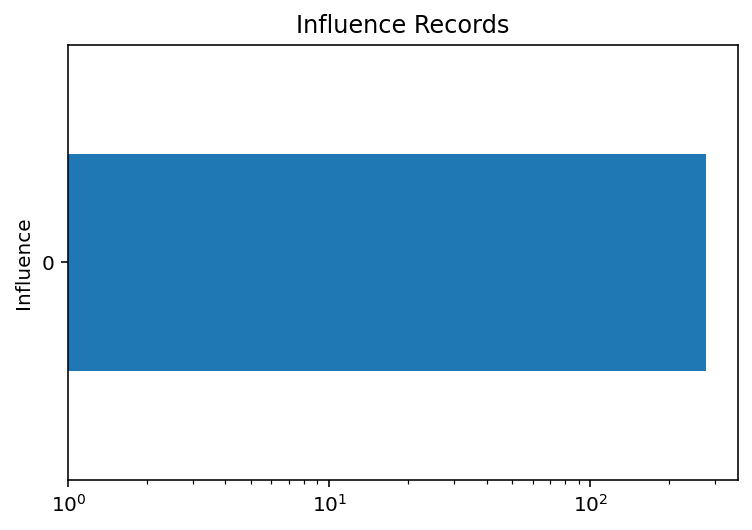

In [ ]:
tmp_influence.plot.barh(title="Influence Records", xlabel="Influence", ylabel="Number of records", log=True)

### &#9759; NLP Features

* fkre_score
* fkgl_score
* message_exper
* commit_exper
* word_cnt
* sentence_cnt

#### &#9759; Test

In [ ]:
email_0 = df_email.loc[0]

In [ ]:
email_0

id                                                                    59
url                    https://lkml.iu.edu/hypermail/linux/kernel/200...
mailing_list_id                                                        1
email_id                                                  20200801175938
message_id                       20200801215806.2659-1-cengiz@kernel.wtf
reply_to_url                                                        None
author_id                                                             35
timestamp_sent                                                1596319178
timestamp_recv                                                1596322778
subject                [PATCH v5] staging: atomisp: move null check t...
body                   `find_gmin_subdev()` that returns a pointer to...
clean_body             `find_gmin_subdev()` that returns a pointer to...
thread_id                    20200731083856.GF3703480@smile.fi.intel.com
persuasion                                         

In [ ]:
txt_to_spacy = text_to_spacy_nlp(email_body=email_0.clean_body)

In [ ]:
txt_to_spacy

`find_gmin_subdev()` that returns a pointer to `struct
gmin_subdev` can return NULL.

In `gmin_v2p8_ctrl()` there's a call to this function but the
possibility of a NULL was not checked before its being dereferenced,
i.e.:

  /* Acquired here --------v */
  struct gmin_subdev *gs = find_gmin_subdev(subdev);

  /*  v------Dereferenced here */
  if (gs->v2p8_gpio >= 0) {
      ...
  }

With this change we're null checking `find_gmin_subdev()` result
and we return an error if that's the case. We also WARN()
for the sake of debugging.

Signed-off-by: Cengiz Can <cengiz@xxxxxxxxxx>
Reported-by: Coverity Static Analyzer CID 1465536
Suggested-by: Mauro Carvalho Chehab <mchehab@xxxxxxxxxx>
Signed-off-by: Cengiz Can <cengiz@xxxxxxxxxx>

-- 
2.27.0



In [ ]:
sentence_cnt = sentence_count(spacy_txt=txt_to_spacy)
sentence_cnt

5

In [ ]:
word_cnt = word_count(spacy_txt=txt_to_spacy)
word_cnt

137

In [ ]:
syllables_cnt = sum([count_syllables(s) for s in retrieve_words(spacy_txt=txt_to_spacy)])
syllables_cnt

157

#### &#9759; Deployment

In [ ]:
df_email['txt_to_spacy'] = df_email.apply(lambda row: text_to_spacy_nlp(email_body=row.clean_body), axis=1)

In [ ]:
df_email['sentence_cnt'] = df_email.apply(lambda row: sentence_count(spacy_txt=row.txt_to_spacy), axis=1)

In [ ]:
df_email['word_cnt'] = df_email.apply(lambda row: word_count(spacy_txt=row.txt_to_spacy), axis=1)

In [ ]:
df_email['syllables_cnt'] = df_email.apply(lambda row: sum([count_syllables(s) for s in retrieve_words(spacy_txt=row.txt_to_spacy)]), axis=1)

In [ ]:
df_email['fkre_score'] = df_email.apply(lambda row: fkre_score(
    total_words=row.word_cnt, 
    total_sentences=row.sentence_cnt, 
    total_syllables=row.syllables_cnt), axis=1)

In [ ]:
df_email['fkgl_score'] = df_email.apply(lambda row: fkgl_score(
    total_words=row.word_cnt, 
    total_sentences=row.sentence_cnt, 
    total_syllables=row.syllables_cnt), axis=1)

In [ ]:
df_email.head()

,id,url,mailing_list_id,email_id,message_id,reply_to_url,author_id,timestamp_sent,timestamp_recv,subject,...,thread_id,persuasion,reply_to_message_id,exert_influence,txt_to_spacy,sentence_cnt,word_cnt,syllables_cnt,fkre_score,fkgl_score
0,59,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801175938,20200801215806.2659-1-cengiz@kernel.wtf,None,35,1596319178,1596322778,[PATCH v5] staging: atomisp: move null check t...,...,20200731083856.GF3703480@smile.fi.intel.com,Unknown,20200731083856.GF3703480@smile.fi.intel.com,0,"(`, find_gmin_subdev, (, ), `, that, returns, ...",5,137,157,82.07000000,8.62000000
1,34,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801021814,202007312237.4F385EB3@keescook,None,23,1596262694,1596266294,Re: [PATCH v5 13/36] vmlinux.lds.h: add PGO an...,...,20200731230820.1742553-1-keescook@chromium.org,Unknown,20200801035128.GB2800311@rani.riverdale.lan,0,"(On, Fri, ,, Jul, 31, ,, 2020, at, 11:51:28PM,...",119,1856,1897,104.54000000,2.55000000
2,35,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801021841,202008011403.PtFkHpqE%lkp@intel.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,24,1596262721,1596266321,Re: [PATCH v3 21/23] device-dax: Add an 'align...,...,159625241660.3040297.3801913809845542130.stgit...,Unknown,159625241660.3040297.3801913809845542130.stgit...,0,"(Hi, Dan, ,, \n\n, Thank, you, for, the, patch...",18,1031,1141,55.07000000,19.81000000
3,39,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,202008010218140,202008011419.67BkWnAl%lkp@intel.com,None,24,1596262694,1596266294,Re: [PATCH v3 21/23] device-dax: Add an 'align...,...,159625241660.3040297.3801913809845542130.stgit...,Unknown,159625241660.3040297.3801913809845542130.stgit...,0,"(Hi, Dan, ,, \n\n, Thank, you, for, the, patch...",21,1378,1534,46.05000000,23.14000000
4,40,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801053958,s5h7dui902e.wl-tiwai@suse.de,https://lkml.iu.edu/hypermail/linux/kernel/200...,3,1596274798,1596278398,Re: [PATCH] ALSA: seq: KASAN: use-after-free R...,...,20200801062403.8005-1-qiang.zhang@windriver.com,Unknown,20200801062403.8005-1-qiang.zhang@windriver.com,0,"(On, Sat, ,, 01, Aug, 2020, 08:24:03, +0200, ,...",124,1572,1279,125.14000000,-1.05000000
